In [1]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.base import clone
import seaborn as sns
from tqdm import tqdm_notebook

import sklearn
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler

### Generate the problem / prepare selected datasets

In [2]:
nrows = None

In [3]:
numerical_features_index = [0, 2, 4, 10, 11, 12]

data_train = pd.read_csv('../datasets/Adult income dataset/adult.data', nrows=nrows, header=None)
y_train = data_train.loc[:, data_train.columns[-1]]
gender_train = data_train.loc[:, data_train.columns[9]]


data_test = pd.read_csv('../datasets/Adult income dataset/adult.test', skiprows=1, header=None)
y_test = data_test.loc[:, data_train.columns[-1]]
gender_test = data_test.loc[:, data_test.columns[9]]

data_train.drop(data_train.columns.difference(numerical_features_index), axis=1, inplace=True)
data_test.drop(data_test.columns.difference(numerical_features_index), axis=1, inplace=True)
data_train = data_train.astype(np.float64)
data_test = data_test.astype(np.float64)



gender_train = gender_train.apply(lambda x: x.strip())
gender_test = gender_test.apply(lambda x: x.strip())

In [4]:
data_train.shape

(32561, 6)

In [5]:
data_train.drop_duplicates(inplace=True)
y_train = y_train.loc[data_train.index]
gender_train = gender_train.loc[data_train.index]

assert data_train.shape[0] == y_train.shape[0] == gender_train.shape[0]

In [6]:
binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train).ravel()
y_test = binarizer.fit_transform(y_test).ravel()

In [7]:
gender_binarizer = LabelBinarizer()
gender_binary = gender_binarizer.fit_transform(gender_test.values).ravel()

In [8]:
scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [10]:
random_seed=777 #tri topora

In [11]:
clf_base = LogisticRegression(random_state=random_seed)

In [12]:
clf = clone(clf_base)

clf.fit(data_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=777, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
print('Initial accuracy of classification: {}'.format(accuracy_score(y_test, clf.predict(data_test))))

Initial accuracy of classification: 0.8134021251765862


In [14]:
male_entries_index = gender_train[gender_train == 'Male'].index
female_entries_index = gender_train[gender_train == 'Female'].index

male_entries_test_index = gender_test[gender_test == 'Male'].index
female_entries_test_index = gender_test[gender_test == 'Female'].index

In [15]:
n0 = data_train[gender_train == 'Male'].shape[0]
n1 = data_train[gender_train == 'Female'].shape[0]

emperical_histogram_male = np.ones_like(male_entries_index) / n0

emperical_histogram_female = np.ones_like(female_entries_index) / n1

In [16]:
C = ot.dist(data_train[gender_train == 'Male'], data_train[gender_train == 'Female'])

In [17]:
coupling1 = ot.sinkhorn(emperical_histogram_male, emperical_histogram_female, C, reg=0.1, numItermax=10000000, verbose=True)

It.  |Err         
-------------------
    0|5.939428e-05|
   10|1.604879e-05|
   20|8.439871e-06|
   30|5.327625e-06|
   40|3.807124e-06|
   50|3.032266e-06|
   60|2.586204e-06|
   70|2.319158e-06|
   80|2.151175e-06|
   90|2.053338e-06|
  100|2.002922e-06|
  110|1.971406e-06|
  120|1.949905e-06|
  130|1.935109e-06|
  140|1.927577e-06|
  150|1.923246e-06|
  160|1.918330e-06|
  170|1.911398e-06|
  180|1.904204e-06|
  190|1.897923e-06|
It.  |Err         
-------------------
  200|1.887434e-06|
  210|1.869270e-06|
  220|1.847622e-06|
  230|1.829218e-06|
  240|1.814049e-06|
  250|1.800402e-06|
  260|1.790732e-06|
  270|1.777456e-06|
  280|1.753040e-06|
  290|1.717395e-06|
  300|1.662943e-06|
  310|1.610069e-06|
  320|1.555416e-06|
  330|1.500702e-06|
  340|1.436503e-06|
  350|1.370897e-06|
  360|1.305950e-06|
  370|1.252790e-06|
  380|1.204108e-06|
  390|1.159856e-06|
It.  |Err         
-------------------
  400|1.123485e-06|
  410|1.094470e-06|
  420|1.067601e-06|
  430|1.042934e-06|
  4

/home/grapefroot/datascience3/lib/python3.6/site-packages/ot/bregman.py:371: RuntimeWarning: overflow encountered in true_divide
  u = 1. / np.dot(Kp, v)


In [18]:
coupling = ot.emd(emperical_histogram_male, emperical_histogram_female, C, numItermax=1000000000)

In [19]:
num = 100

In [20]:
y_first = y_train[gender_train == 'Male']
y_second = y_train[gender_train == 'Female']
print('class 0 size {}'.format(y_first.shape))
print('class 1 size {}'.format(y_second.shape))

class 0 size (21614,)
class 1 size (10720,)


In [21]:
from mapper import full_repair, partial_repair, random_repair
from utils import balanced_error_rate, disparate_impact, likelihood_ratio

In [22]:
acs = []
dims = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = partial_repair(repair_value, data_train[gender_train == 'Male'], data_train[gender_train == 'Female'], y_first, y_second, coupling)
    clf1 = clone(clf_base)
    clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_test, clf1.predict(data_test))
    disparate_im = disparate_impact(clf1.predict(data_test), gender_binary)
    acs.append(accuracy_sc)
    dims.append(disparate_im)

In [23]:
acs_1 = []
dims_1 = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = partial_repair(repair_value, data_train[gender_train == 'Male'], data_train[gender_train == 'Female'], y_first, y_second, coupling1)
    clf1 = clone(clf_base)
    clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_test, clf1.predict(data_test))
    disparate_im = disparate_impact(clf1.predict(data_test), gender_binary)
    acs_1.append(accuracy_sc)
    dims_1.append(disparate_im)

In [24]:
acs_2 = []
dims_2 = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = random_repair(repair_value, 0.5, data_train[gender_train == 'Male'], data_train[gender_train == 'Female'], y_first, y_second, coupling)
    clf1 = clone(clf_base)
    clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_test, clf1.predict(data_test))
    disparate_im = disparate_impact(clf1.predict(data_test), gender_binary)
    acs_2.append(accuracy_sc)
    dims_2.append(disparate_im)

In [25]:
acs_3 = []
dims_3 = []

for repair_value in tqdm_notebook(np.linspace(0, 1, num=num)):
    X_new, y_new = random_repair(repair_value, 0.5, data_train[gender_train == 'Male'], data_train[gender_train == 'Female'], y_first, y_second, coupling1)
    clf1 = clone(clf_base)
    clf1.fit(X_new, y_new)
    accuracy_sc = accuracy_score(y_test, clf1.predict(data_test))
    disparate_im = disparate_impact(clf1.predict(data_test), gender_binary)
    acs_3.append(accuracy_sc)
    dims_3.append(disparate_im)

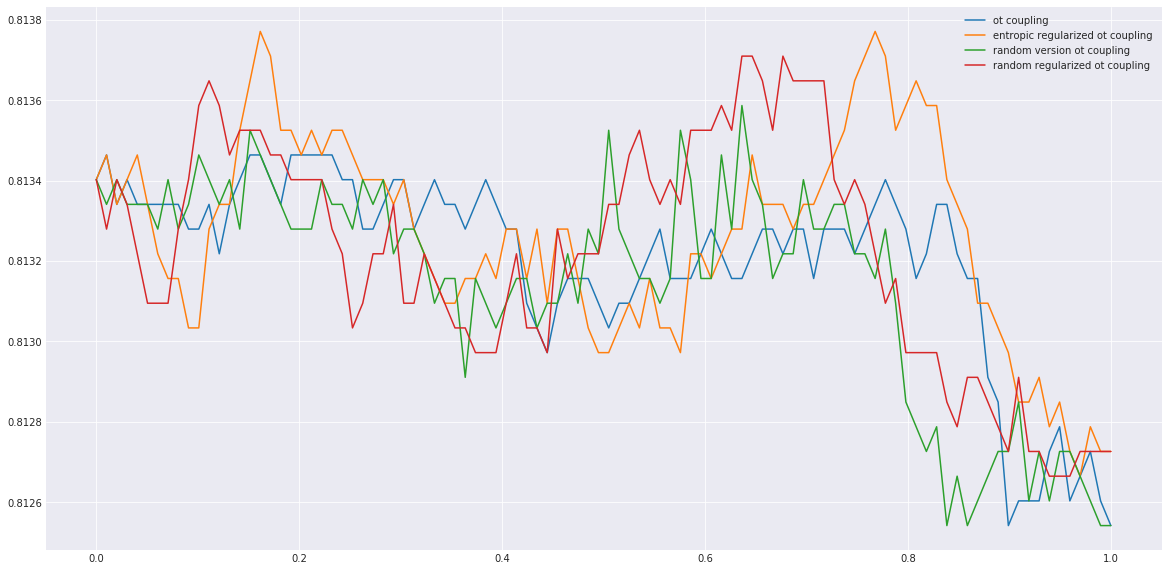

In [26]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(20, 10))
    plt.plot(np.linspace(0, 1, num), acs, label='ot coupling')
    plt.plot(np.linspace(0, 1, num), acs_1, label='entropic regularized ot coupling')
    plt.plot(np.linspace(0, 1, num), acs_2, label='random version ot coupling')
    plt.plot(np.linspace(0, 1, num), acs_3, label='random regularized ot coupling')
    plt.legend()

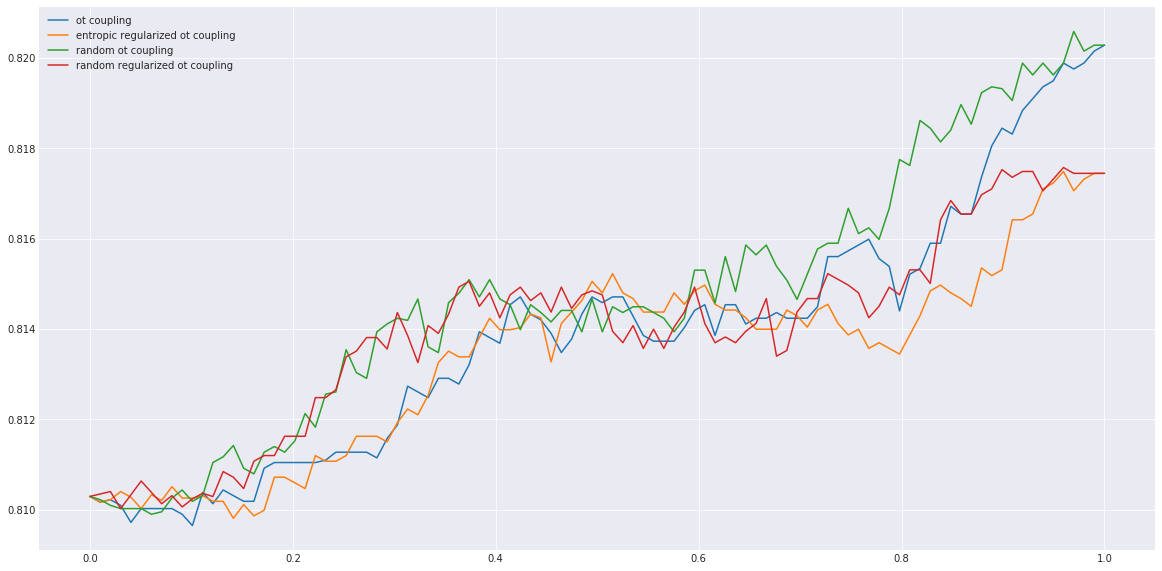

In [27]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(20, 10))
    plt.plot(np.linspace(0, 1, num), dims, label='ot coupling')
    plt.plot(np.linspace(0, 1, num), dims_1, label='entropic regularized ot coupling')
    plt.plot(np.linspace(0, 1, num), dims_2, label='random ot coupling')
    plt.plot(np.linspace(0, 1, num), dims_3, label='random regularized ot coupling')
    plt.legend()
    plt.show()

### Show that different solutions for the same transporation problem can have different target metric value

### Explore how the regularized barycenters are defined, try to apply them to the problem

### Use the regularized transport maps instead of usual ones